In [1]:
# Setup, Version check and Common imports

# Python ≥3.8 is required
import sys
assert sys.version_info >= (3, 5)


# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

from tensorflow import keras
from tensorflow.keras import layers

# to make this notebook's output stable across runs
np.random.seed(42)

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

print('Python version: ', sys.version_info)
print('TF version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('GPU is', 'available' if tf.config.list_physical_devices('GPU') else 'NOT AVAILABLE')

Python version:  sys.version_info(major=3, minor=11, micro=11, releaselevel='final', serial=0)
TF version:  2.18.0
Keras version:  3.8.0
GPU is available


**1. Data Fetching and Loading**

In [2]:
# Download the Flowers dataset: https://www.kaggle.com/datasets/imsparsh/flowers-dataset

# Create folder flower_photos
# Inside this folder there are 5 subfolders, one for each category

!curl -O https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

!tar -xzvf flower_photos.tgz

!rm flower_photos.tgz



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  218M  100  218M    0     0  18.0M      0  0:00:12  0:00:12 --:--:-- 22.9M
flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.jpg
flower_photos/roses/14019883858_e5d2a0ec10_n.jpg
flower_photos/roses/8035908422_87220425d2_n.jpg
flower_photos/roses/14747962886_2bff6bb323_m.jpg
flower_photos/roses/4356781875_92c5cd93c0.jpg
flower_photos/roses/8524505546_b242bd4928_n.jpg
flower_photos/roses/9406573080_60eab9278e_n.jpg
flower_photos/roses/6039330368_c30ed224c4_m.jpg
flower_photos/roses/14414100710_753a36fce9.jpg
flower_

In [3]:
os.chdir('flower_photos')

path = os.getcwd()



In [4]:
# Check the total number of images

import pathlib

data_dir = pathlib.Path(path)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [5]:
# Creation of the dataset objects
# The images in the folders are not divided in train and validation datasets
# The following code divides samples into 80% training and 20% validation. No test set is created
# Check details from previous class and also here: https://www.tensorflow.org/tutorials/load_data/images


batch_size = 32
IMG_SIZE = (180, 180)

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=batch_size,
)

class_names = train_ds.class_names


train_ds = train_ds.cache().prefetch(1)
val_ds = val_ds.cache().prefetch(1)



Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Using 734 files for validation.


In [6]:
# Dataset detailed information

print('Nr. of classes: ', len(class_names))
print('Classes: ', class_names)

# Cardinality
print('Cardinalidade Treino: ', train_ds.cardinality().numpy())
print('Cardinalidade Validacão: ', val_ds.cardinality().numpy())



# Explain the cardinality values

Nr. of classes:  5
Classes:  ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Cardinalidade Treino:  92
Cardinalidade Validacão:  23


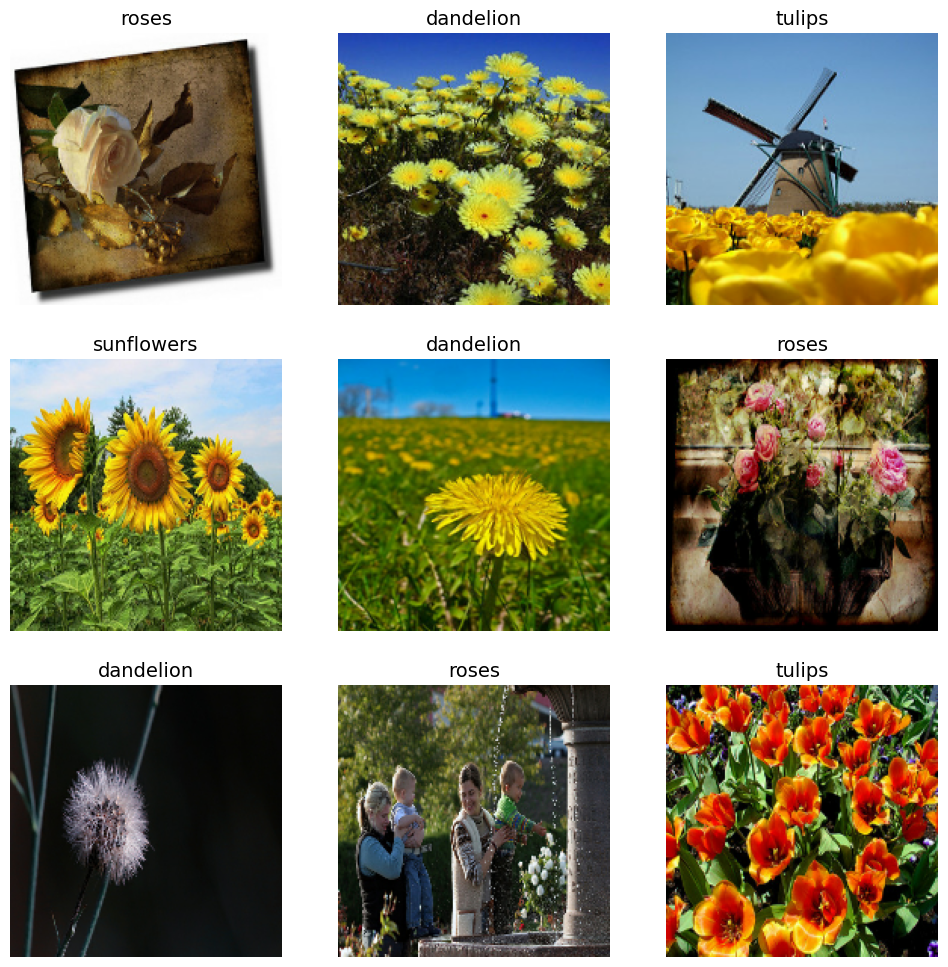

In [7]:
# Visualize a few examples

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy()/255.)
        plt.title(class_names[labels[i]])
        plt.axis("off")

[texto do link](https://)**2.	Creating the baseline version of the Neural Network using the Keras Functional API**

In [8]:
# Creation of a baseline CNN

# It must comply with the following constraints:
#   1. Use Keras Functional API
#   2. Use only Conv2D, MaxPooling, Dense, Flatten and Rescaling layers
#   3. Maximum of 5 million parameters
#   4. Without Data Augmentation
#   5. Do not forget Input Rescaling

# https://www.tensorflow.org/api_docs/python/tf/keras/Model
# https://www.tensorflow.org/guide/keras/sequential_model
# https://keras.io/api/layers/

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# FUNCTIONAL API

inputs = keras.Input(shape=(180,180,3))

a = layers.Rescaling(scale = 1./255)(inputs)

b = layers.Conv2D(32, (3, 3), activation='relu')(a)
b = layers.MaxPooling2D((2, 2))(b)

c = layers.Conv2D(64, (3, 3), activation='relu')(b)
c = layers.MaxPooling2D((2, 2))(c)

d = layers.Conv2D(128, (3, 3), activation='relu')(c)
d = layers.MaxPooling2D((2, 2))(d)

# Flatten layer to convert 3D feature maps to 1D feature vectors

e = layers.Flatten()(d)

# Fully connected layers
f = layers.Dense(128, activation='relu')(e)


outputs = layers.Dense(len(class_names), activation='softmax')(f)

model = keras.Model(inputs=inputs, outputs=outputs)




In [9]:
# Check the limit for the maximum number of parameters

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,647,621 (25.36 MB)

 Trainable params: 6,647,621 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Model compilation

#  1. Select the loss function suitable for this situation
#  2. Adopt ADAM optimizer, with default parameterization
#  3. Select accuracy metric to evaluate the model

L = keras.losses.SparseCategoricalCrossentropy()

model.compile(loss=L, optimizer="adam", metrics=["accuracy"])

In [12]:
# Train for 20 epochs

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 0.3565 - loss: 1.5218 - val_accuracy: 0.5531 - val_loss: 1.1006
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5877 - loss: 1.0378 - val_accuracy: 0.6063 - val_loss: 0.9644
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6582 - loss: 0.8823 - val_accuracy: 0.6049 - val_loss: 0.9707
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7138 - loss: 0.7260 - val_accuracy: 0.6403 - val_loss: 0.9689
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7972 - loss: 0.5219 - val_accuracy: 0.6349 - val_loss: 1.1320
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8444 - loss: 0.4381 - val_accuracy: 0.6512 - val_loss: 1.2191
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9026 - loss: 0.2853 - val_accuracy: 0.6444 - val_loss: 1.4701
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9386 - loss: 0.1900 - val_accuracy: 0.6730 -

<Axes: >

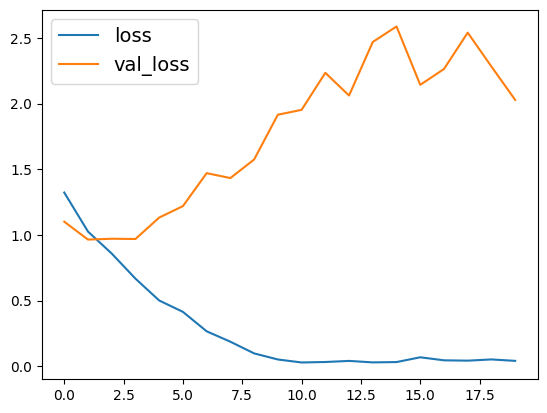

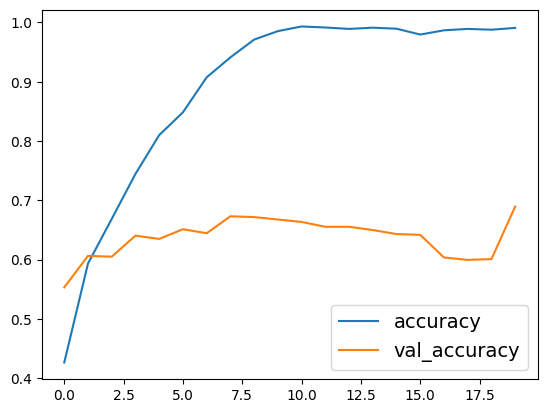

In [14]:
# Visualize results (both accuracy and loss)

import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

**Question:**

1. Analyze results. By looking at each one of the charts, what do you think is happening?

A diminuição da perda (loss) no treino acaba por fazer com que  modelo esteja constantemente a evoluir no treino.

Já os dados no val_loss aumentarem indica um overfitting da rede.

A accuracy vai aumentanddo até 0.9 o que é bom, já a val_accuracy estagna aos ~= 0.7 o que indica que o modelo não está com melhoria progressiva.

2. Suggest possible strategies to enhance results.

Melhorias possiveis seria utilizar Data Augmentation no problema.

**3.	Fighting Overfitting: Data Augmentation**

In [15]:

# Overview on Data Augmentation:
# https://www.tensorflow.org/tutorials/images/data_augmentation

# Model DA1 relies on Keras preprocessing layers to perform Data Augmentation
# https://keras.io/api/layers/preprocessing_layers/image_augmentation/

# The data augmentation module is created using the Sequential API

data_augmentation1 = keras.Sequential([
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(factor=0.5),
])




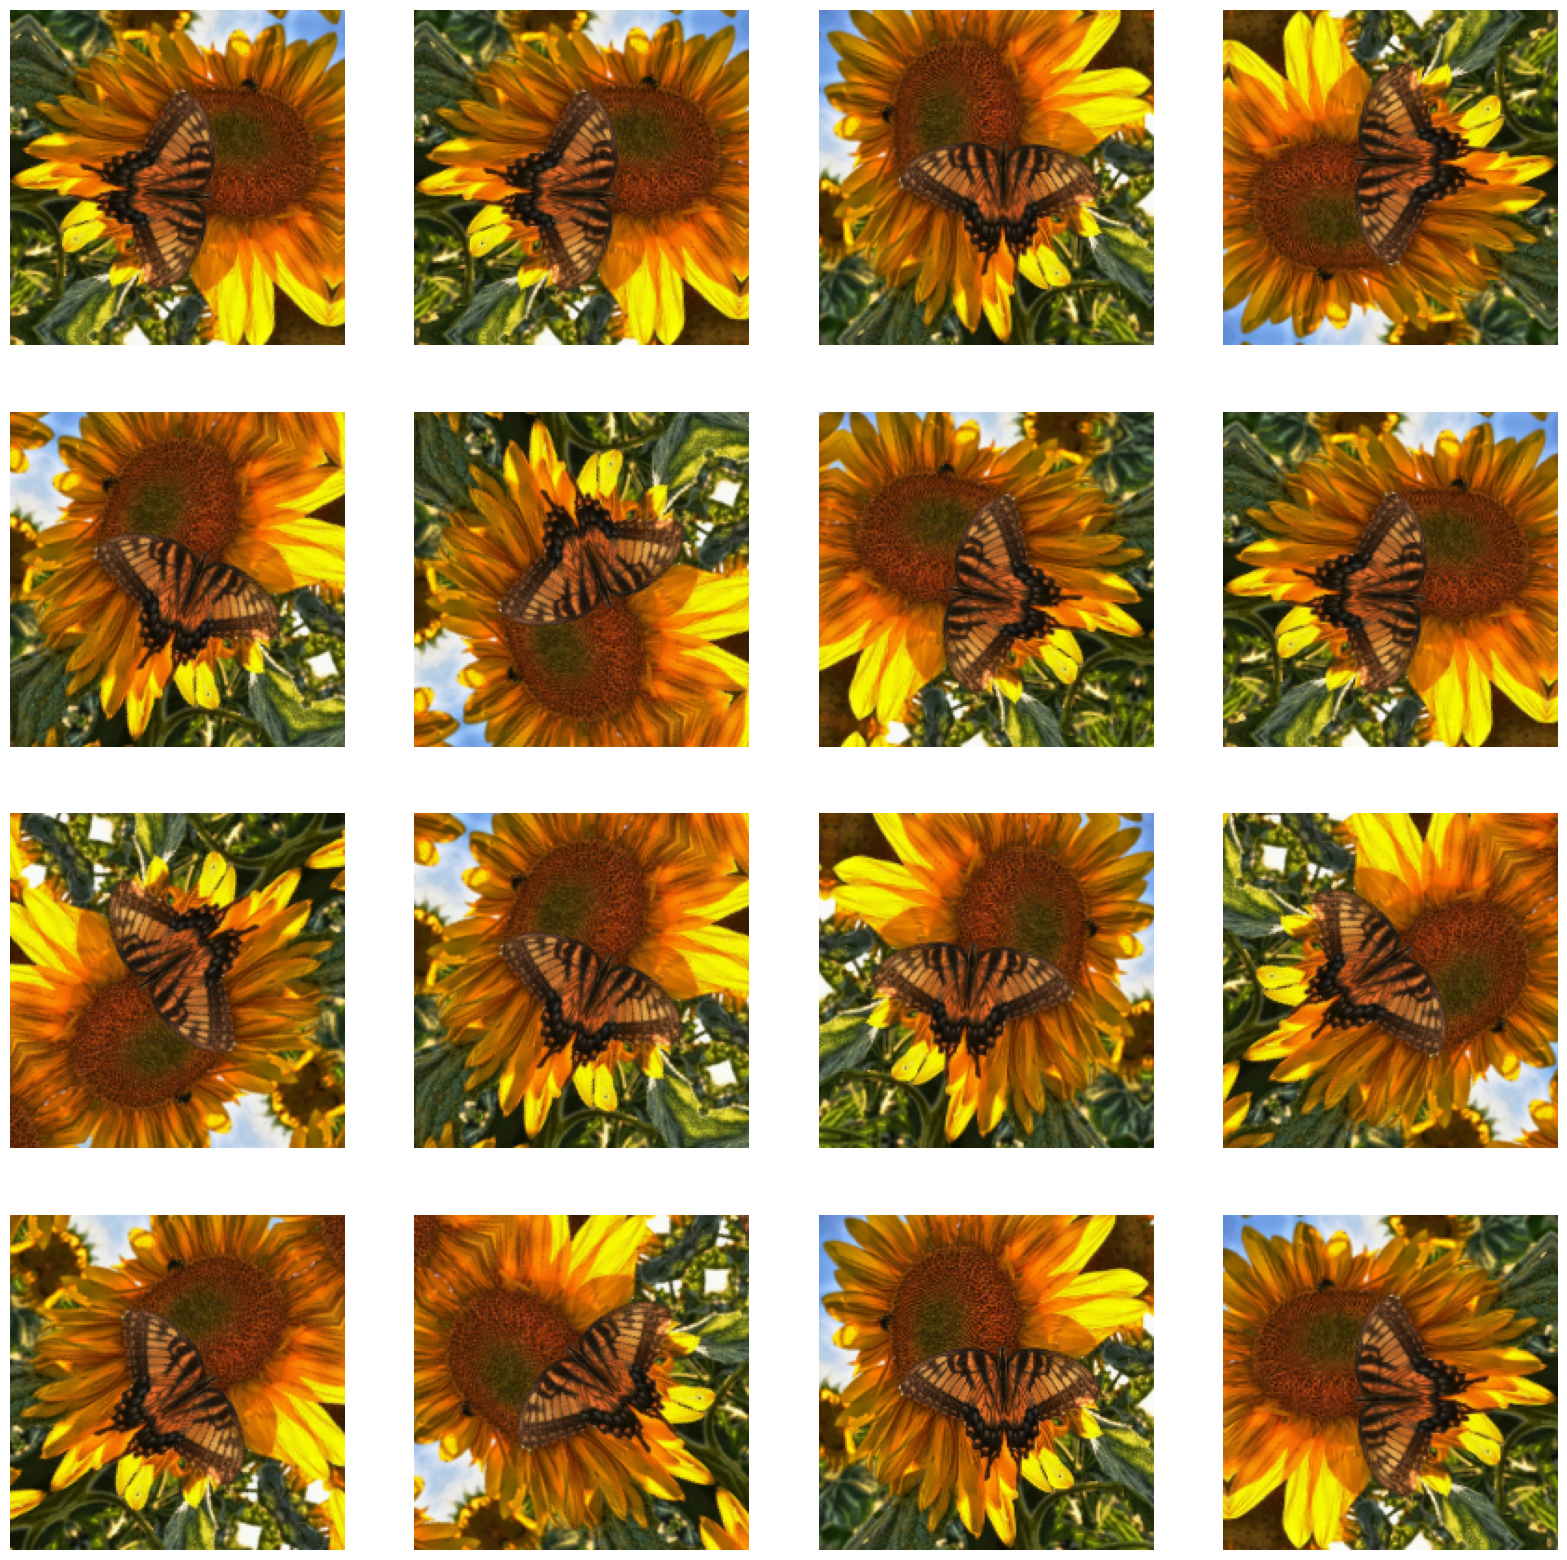

In [16]:
# Visualize examples of augmented images

plt.figure(figsize=(20, 20))
for images, _ in train_ds.take(1):
  for i in range(16):
    augmented_images = data_augmentation1(images)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_images[0].numpy()/255.)
    plt.axis("off")

In [17]:
# Model DA1 with data augmentation

# Keep the previous model and just add the data augmentation layers

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# FUNCTIONAL API

inputs = keras.Input(shape=(180,180,3))

# Data augmentation layers
a = data_augmentation1(inputs)

# Rescaling layer to normalize pixel values to [0, 1]
b = layers.Rescaling(scale=1./255)(a)

# Convolutional layers
c = layers.Conv2D(32, (3, 3), activation='relu')(b)
c = layers.MaxPooling2D((2, 2))(c)

d = layers.Conv2D(64, (3, 3), activation='relu')(c)
d = layers.MaxPooling2D((2, 2))(d)

e = layers.Conv2D(128, (3, 3), activation='relu')(d)
e = layers.MaxPooling2D((2, 2))(e)

# Flatten layer to convert 3D feature maps to 1D feature vectors
f = layers.Flatten()(e)

# Fully connected layers
g = layers.Dense(128, activation='relu')(f)
outputs = layers.Dense(len(class_names), activation='softmax')(g)

model_DA1 = keras.Model(inputs=inputs, outputs=outputs)

In [18]:
# Compile and train Model 2

L = keras.losses.SparseCategoricalCrossentropy()

model_DA1.compile(loss=L, optimizer="adam", metrics=["accuracy"])


history = model_DA1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.3401 - loss: 1.6361 - val_accuracy: 0.5518 - val_loss: 1.1014
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5388 - loss: 1.0821 - val_accuracy: 0.5926 - val_loss: 0.9785
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5957 - loss: 0.9924 - val_accuracy: 0.6172 - val_loss: 0.9508
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6222 - loss: 0.9250 - val_accuracy: 0.6471 - val_loss: 0.8861
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6391 - loss: 0.8877 - val_accuracy: 0.6608 - val_loss: 0.8449
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.6745 - loss: 0.8358 - val_accuracy: 0.6403 - val_loss: 0.8705
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6782 - loss: 0.8262 - val_accuracy: 0.6499 - val_loss: 0.8532
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.6925 - loss: 0.7663 - val_accuracy: 0.6744 - v

<Axes: >

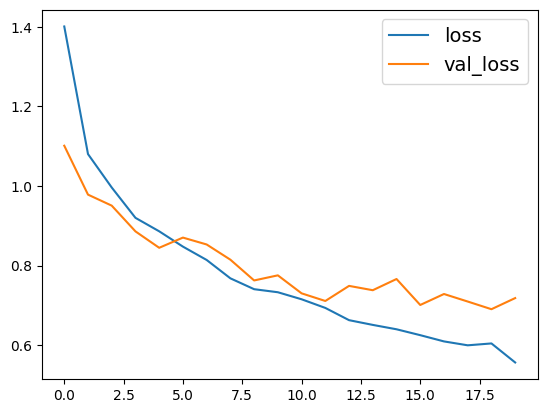

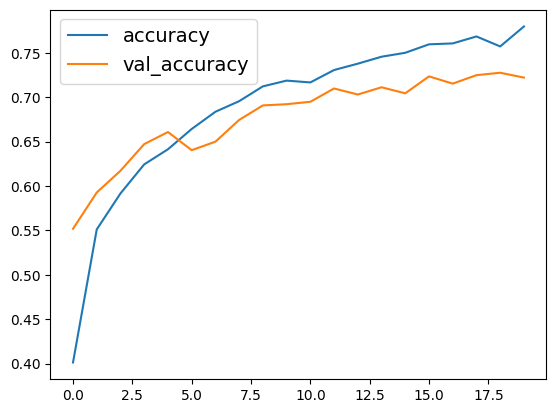

In [19]:
# Visualize results (both accuracy and loss)

import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

**Question:**

1. How do you analyze results? Are they similar to those obtained by the previous model?

O modelo na loss e validation loss acompanhou bem ambas diminuindo ao longo do tempo, o que significa que o modelo estava a aprender bem.

Já na Accuracy e val_accuracy, ela acompanha os dados de treino mostrando um acompanhamento de valores indicando que o modelo está com melhor performance face a dados não vistos do que o anterior. Combatendo assim o problema do modelo anterior que demonstrou overfitting.




In [ ]:
# Create a new data augmentation module - Model DA2

# It should comprise 3 or more pre-processing layers, where, at least, two of them,
# must be different from the ones already used

# Add the pre-processing module to the beggining of the NN
# Compile and train the modified CNN and analyze results

# Constraint: 5 million trainable parameters

# You can use additional strategies to fight overfitting


# CODE GOES HERE - MODEL DA2

# Creation of a baseline CNN

# It must comply with the following constraints:
#   1. Use Keras Functional API
#   2. Use only Conv2D, MaxPooling, Dense, Flatten and Rescaling layers
#   3. Maximum of 5 million parameters
#   4. Without Data Augmentation
#   5. Do not forget Input Rescaling

# https://www.tensorflow.org/api_docs/python/tf/keras/Model
# https://www.tensorflow.org/guide/keras/sequential_model
# https://keras.io/api/layers/


keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# FUNCTIONAL API

inputs = keras.Input(shape=(180,180,3))

# Data augmentation layers
a = data_augmentation1(inputs)

# Rescaling layer to normalize pixel values to [0, 1]
b = layers.Rescaling(scale=1./255)(a)

# Convolutional layers
c = layers.Conv2D(32, (3, 3), activation='relu')(b)
c = layers.MaxPooling2D((2, 2))(c)

d = layers.Conv2D(64, (3, 3), activation='relu')(c)
d = layers.MaxPooling2D((2, 2))(d)

e = layers.Conv2D(128, (3, 3), activation='relu')(d)
e = layers.MaxPooling2D((2, 2))(e)

# Flatten layer to convert 3D feature maps to 1D feature vectors
f = layers.Flatten()(e)

# Fully connected layers
g = layers.Dense(128, activation='relu')(f)
outputs = layers.Dense(len(class_names), activation='softmax')(g)

model_DA1 = keras.Model(inputs=inputs, outputs=outputs)


Epoch 1/50


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None,), output.shape=(None, 20, 20, 6)